<a href="https://colab.research.google.com/github/hahhahhahhe/coding_noob/blob/main/20231128/GI_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

外掛操作

In [16]:
import torch
print(torch.__version__)

2.1.0+cu118


In [17]:
!pwd #看目前的指定位置
!ls  #看指定位置裡的資料

/content
cifar_net.pth  data  sample_data


In [18]:
#from google.colab import drive #掛載到雲端硬碟
#drive.mount('/content/gdrive')

In [19]:
#import os  #位置指定到資料夾
#project_path='/content/gdrive/My Drive/test_ver.1'
#os.chdir(project_path)

使用Cifar-10做影像分類

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

影像預處理

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 5  # batch = 4 改成 batch = 5

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Show Images

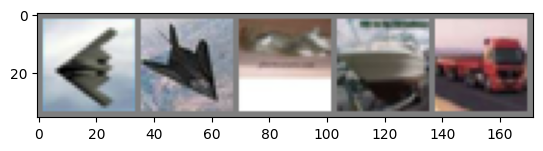

plane plane cat   ship  truck


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

定義卷積類神經網路 (一個簡單的LeNet模型)

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

設置優化器與損失函數

In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0011, momentum=0.9)   # lr = 0.001 改成 lr = 0.002


訓練卷積類神經網路

In [44]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.138
[1,  4000] loss: 1.103
[1,  6000] loss: 1.097
[1,  8000] loss: 1.109
[1, 10000] loss: 1.104
[2,  2000] loss: 1.020
[2,  4000] loss: 1.060
[2,  6000] loss: 1.026
[2,  8000] loss: 1.030
[2, 10000] loss: 1.046
Finished Training


保存已訓練好的模型

In [53]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

進行測試

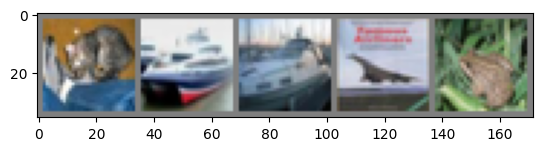

GroundTruth:  cat   ship  ship  plane frog 


In [54]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))


In [55]:
#net = Net()
#net.load_state_dict(torch.load(PATH))

In [56]:
outputs = net(images)

In [57]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))

Predicted:  cat   car   car   plane deer 


In [58]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %
